## Mount drive

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

## Install requirements

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
#!pip3 install pillow==4.1.1 #if error: module 'PIL._webp' has no attribute 'HAVE_WEBPANIM'
#%reload_ext autoreload #if error: module 'PIL._webp' has no attribute 'HAVE_WEBPANIM'
#%autoreload #if error: module 'PIL._webp' has no attribute 'HAVE_WEBPANIM'

## Import libraries

In [0]:
import os
import logging
import sys
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

from torchvision.datasets import VisionDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, vgg11, vgg19, vgg19_bn

from PIL import Image
from tqdm import tqdm
import numpy as np

import random
import collections
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

## Define dataset class


In [0]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def make_dataset(dir, class_to_idx, split, extensions=None, is_valid_file=None):
    images = []

    with open(os.path.join(dir, '..', split+'.txt')) as f:
        images_file = f.read().splitlines()
        for image_path in images_file:
            path = os.path.join(dir, image_path)
            target,_ = image_path.split("/")
            if target in class_to_idx.keys():
                item = (path, class_to_idx[target])
                images.append(item)
    return images

class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, valid_size = 0.5):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')

        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''

        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, self.split)
        if len(samples) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root))

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if (d.is_dir() and d.name != 'BACKGROUND_Google')]
        else:
            classes = [d for d in os.listdir(dir) if (os.path.isdir(os.path.join(dir, d)) and d != 'BACKGROUND_Google')]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def get_index_by_class(self, image_class):
        '''
        get_items_by_class should return every item's index of the given class
        Args:
            image_class (String): class_name
        
        Returns:
            list: [index, ...] where index is the index of one of the element of the given class
        '''
        indexes = []
        for i, item in enumerate(self.samples):
            if item[1] == self.class_to_idx[image_class]:
                indexes.append(i)
        return indexes

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        image_path, target = self.samples[index]
        image, label = (pil_loader(image_path), target) # Provide a way to access image and label via index
                                                        # Image should be a PIL Image
                                                        # label can be int

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.samples) # Provide a way to get the length (number of elements) of the dataset
        return length


## Download Dataset

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'

## Set Arguments

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # Removed extra Background class

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 60      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10


## Prepare Training

In [0]:
def train_step(net, criterion, optimizer, current_step, train_losses, train_accuracies, train_dataloader):
  # Iterate over the dataset
  step = 1
  train_losses.append(0)
  train_accuracies.append(0)
  
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update train losses
    train_losses[-1] += loss.item()
    #Update train accuracies
    train_accuracies[-1] += torch.sum(preds == labels.data).data.item()/len(labels.data)

    # Log loss and accuracy
    if current_step % LOG_FREQUENCY == 0:
      print('\tStep {}, Loss {}, Accuracy = {}%'.format(current_step, loss.item(), train_accuracies[-1]*100/step))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
    step += 1

  train_losses[-1] /= step
  train_accuracies[-1] /= step

  return current_step, train_losses, train_accuracies

In [0]:
def valid_step(net, criterion, valid_losses, valid_accuracies, valid_dataloader, current_step):
  step = 1
  valid_losses.append(0)
  valid_accuracies.append(0)
  
  for images, labels in valid_dataloader:

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs_valid = net(images)

    # Get predictions
    _, preds = torch.max(outputs_valid.data, 1)

    # Update valid losses
    valid_losses[-1] += criterion(outputs_valid, labels).item()
    #Update valid accuracies
    valid_accuracies[-1] += torch.sum(preds == labels.data).data.item()/len(labels.data)

    current_step += 1
    step += 1

  valid_losses[-1] /= step
  valid_accuracies[-1] /= step

  print('\tValid_loss = {}, Valid_accuracy = {}%'.format(valid_losses[-1], valid_accuracies[-1]*100))

  return valid_losses, valid_accuracies, current_step

In [0]:
def model_train(net, optimizer, scheduler, stats, epochs=NUM_EPOCHS):
  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  current_step_valid = 0
  # Start iterating over the epochs
  for epoch in range(epochs):

    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, epochs, scheduler.get_lr()))

    net.train() # Sets module in training mode
    current_step, stats['train_losses'], stats['train_accuracies'] = train_step(net, criterion, optimizer, current_step, stats['train_losses'], stats['train_accuracies'], train_dataloader)

    # Step the scheduler
    scheduler.step()

    net.train(False) # Sets module in evaluation mode
    #Testing on validation set
    stats['valid_losses'], stats['valid_accuracies'], current_step_valid = valid_step(net, criterion, stats['valid_losses'], stats['valid_accuracies'], valid_dataloader, current_step_valid)

  return stats

In [0]:
def model_test(test_dataloader, net1, net2=None):
  net1 = net1.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net1.train(False) # Set Network to evaluation mode

  step = 1

  #If using two models
  if net2 is not None:
    for net in net2:
      net = net.to(DEVICE)
      net.train(False)

  accuracy = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass 1
    outputs = net1(images).data

    #Forward pass 2 and get predictions
    if net2 is not None:
      for net in net2:
        outputs += net(images).data
      _, preds = torch.max(outputs/(len(net2)+1), 1)
    else:
      _, preds = torch.max(outputs, 1)

    # Update Corrects
    accuracy += torch.sum(preds == labels.data).data.item()/ float(len(labels.data))

    step += 1

  accuracy /= step

  print('Test Accuracy: {}%'.format(accuracy*100))

Creating methods to save and plot values

In [0]:
#Use to save values of hyper-parameters
def save_values(valid_losses, valid_accuracies, first_param, second_param, best_values):
  i = np.argmin(valid_losses)
  if len(best_values) < 10:
    best_values[valid_losses[i]] = (valid_accuracies[i], first_param, second_param)
  elif list(best_values.keys())[0] > valid_losses[i]:
    best_values.popitem()
    best_values[valid_losses[i]] = (valid_accuracies[i], first_param, second_param)
  return collections.OrderedDict(sorted(best_values.items()))

In [0]:
def plot_2d(stats):
  fig, (ax1, ax2) = plt.subplots(2)

  #Plotting losses
  ax1.plot(stats['train_losses'])  
  ax1.plot(stats['valid_losses'])  
  #ax1.title("Model Loss")  
  ax1.set_ylabel("loss")  
  ax1.set_xlabel("epochs")  
  ax1.legend(['train', 'valid'], loc='upper left')

  #Plotting accuracies
  ax2.plot(stats['train_accuracies'])  
  ax2.plot(stats['valid_accuracies'])  
  #ax2.title("Model Accuracy")  
  ax2.set_ylabel("accuracy")  
  ax2.set_xlabel("epochs")  
  ax2.legend(['train', 'valid'], loc='upper left')

In [0]:
#Use to plot 3D plot a hyper-parameters / loss
def D_plot(xdata, ydata, zdata, xlabel, ylabel, zlabel='loss'):
  fig = plt.figure()
  ax = plt.axes(projection="3d")

  # Data for three-dimensional scattered points
  ax.scatter3D(xdata, ydata, zdata, cmap="Blues")

  ax.set_xlabel(xlabel)  
  ax.set_ylabel(ylabel)
  ax.set_zlabel(zlabel)

### Defining loss

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

## Save and load models

In [0]:
#torch.save(net_pretrained_vgg_19.state_dict(), "./vgg_19")

In [0]:
#Load model
#net_pretrained_vgg_19_bn = vgg19_bn()
#net_pretrained_vgg_19_bn.classifier[6] = nn.Linear(4096, NUM_CLASSES)
#net_pretrained_vgg_19_bn.load_state_dict(torch.load("./vgg_19_bn"))

## Define Data Preprocessing

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

## Prepare Dataset

In [0]:
# Prepare Pytorch train/test Datasets
#train_dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=train_transform)
#test_dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=eval_transform)
train_dataset = Caltech(DATA_DIR, transform=train_transform, split='train')
test_dataset = Caltech(DATA_DIR, transform=eval_transform, split='test')

#train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
#test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]
#train_dataset = Subset(train_dataset, train_indexes)
#test_dataset = Subset(test_dataset, test_indexes)

# Creating data indices for training and validation splits:
train_indices = []
val_indices = []

for image_class in train_dataset.classes:
  class_indices = train_dataset.get_index_by_class(image_class)
  np.random.shuffle(class_indices)
  split = int(np.floor(0.5 * len(class_indices)))
  train_indices = train_indices + class_indices[split:]
  val_indices = val_indices + class_indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_indices)))
print('Validation Dataset: {}'.format(len(val_indices)))
print('Test Dataset: {}'.format(len(test_dataset)))

## Train

### Search for best learning rate - batch_size, Adam

In [0]:
#best_values = dict()
#best_accuracy = 0

#max_count = 30
#cs_epochs = 15
#for count in range(max_count):
  #lr = 10**random.uniform(-5, -3) #Initially considered uniform(-5, -2), than uniform(-5, -3)
  #batch_size = random.choice([64, 128]) #Initially choice([64, 128, 256, 512]), than choice([64, 128])

  #stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

  #print("Iteration {}/{}, lr = {}, gamma = {}".format(count, max_count, lr, batch_size))

  #train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=train_sampler) 
  #valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=valid_sampler) 

  #net = alexnet()
  #net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  #parameters_to_optimize = net.parameters()
  #optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)             
  #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  #stats = model_train(net, optimizer, scheduler, stats, epochs=cs_epochs)

  #Saving best 10 results considering validation loss
  #best_values = save_values(stats['valid_losses'], stats['valid_accuracies'], net, [lr, batch_size], best_values)

  #if stats['valid_accuracies'][-1] > best_accuracy:
    #best_net = copy.deepcopy(net)
    #best_accuracy = stats['valid_accuracies'][-1]

  #print("")

In [0]:
#print(best_values)

In [0]:
#losses = []
#rates = []
#batch_sizes = []
#for item in list(best_values.items()):
  #if item[0] < 4.4:   #Filtring values to better understand from graph
    #rates.append(item[1][1])
    #batch_sizes.append(item[1][2])
    #losses.append(item[0])
#D_plot(rates, batch_sizes, losses, 'Learning rate', 'batch_size')

Best learning rate = 1e-4 and best batch size = 64

### Search for best betas, Adam
Using learning rate previously found

In [0]:
#best_values = dict()
#best_accuracy = 0

#lr = 1e-4 #Found previously
#batch_size = 64 #Found previously

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=train_sampler) 
#valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=valid_sampler) 

#max_count = 30
#cs_epochs = 10
#for count in range(max_count):
  #beta1 = random.uniform(0.82, 0.90) #Initially uniform(0.8, 0.999), than uniform(0.82, 0.90)
  #beta2 = random.uniform(0.90, 0.99) #Initially uniform(0.8,0.999), than uniform(0.90, 0.99)

  #stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

  #print("Iteration {}/{}, betas = ({}, {})".format(count, max_count, beta1, beta2))

  #net = alexnet()
  #net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  #parameters_to_optimize = net.parameters()
  #optimizer = optim.Adam(parameters_to_optimize, lr=lr, betas=(beta1, beta2), weight_decay=WEIGHT_DECAY)
  #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  #stats = model_train(net, optimizer, scheduler, stats, epochs=cs_epochs)

  #Saving best 10 results considering validation loss
  #best_values = save_values(stats['valid_losses'], stats['valid_accuracies'], beta1, beta2, best_values)

  #if stats['valid_accuracies'][-1] > best_accuracy:
    #best_net = copy.deepcopy(net)
    #best_accuracy = stats['valid_accuracies'][-1]

  #print("")

In [0]:
#print(best_values)

In [0]:
#losses = []
#beta1 = []
#beta2 = []
#for item in list(best_values.items()):
  #if item[0] < 3: #Filtring values to better understand from graph
    #beta1.append(item[1][1])
    #beta2.append(item[1][2])
    #losses.append(item[0])
#D_plot(beta1, beta2, losses, 'Beta1', 'Beta2')

Best couple found is beta1 = 0.90 and beta2 = 0.94, because they were those with no overfitting and best results in 10 epochs

### Training first model
Training model with best hyper-parameters found

In [0]:
LR = 1e-4
BATCH_SIZE = 64
BETAS = (0.90, 0.94)

#### Prepare dataloaders

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=train_sampler) #Shuffling in sampler
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=valid_sampler) #Shuffling in sampler

#### Prepare Network

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
# Define optimizer
# An optimizer updates the weights based on loss
# We use Adam
#optimizer = optim.Adam(parameters_to_optimize, lr=LR, betas=BETAS, weight_decay=WEIGHT_DECAY)
optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

In [0]:

stats = model_train(net, optimizer, scheduler, stats, epochs=40)

#### Plot Losses and accuracies


In [0]:
plot_2d(stats)

### Search for best learning rate - batch_size, SGD + Nesterov Momentum
Using hyper-parameters found previously

In [0]:
#best_values = dict()
#best_accuracy = 0

#max_count = 30
#cs_epochs = 10
#for count in range(max_count):
  #lr = 10**random.uniform(-4, -2) #Initially considered uniform(-5, -2), than uniform(-4, -2)
  #batch_size = random.choice([64, 128]) #Initially choice([64, 128, 256, 512]), than choice([64, 128])

  #stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

  #print("Iteration {}/{}, lr = {}, gamma = {}".format(count, max_count, lr, batch_size))

  #train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=train_sampler) 
  #valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=valid_sampler) 

  #net = alexnet()
  #net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  #parameters_to_optimize = net.parameters()
  #optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True) 
  #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  #stats = model_train(net, optimizer, scheduler, stats, epochs=cs_epochs)

  #Saving best 10 results considering validation loss
  #best_values = save_values(stats['valid_losses'], stats['valid_accuracies'], lr, batch_size, best_values)

  #if stats['valid_accuracies'][-1] > best_accuracy:
    #best_net = copy.deepcopy(net)
    #best_accuracy = stats['valid_accuracies'][-1]

  #print("")

In [0]:
#print(best_values)

In [0]:
#losses = []
#rates = []
#batch_sizes = []
#for item in list(best_values.items()):
  #if item[0] < 4.4:    #Filtring values to better understand from graph
    #rates.append(item[1][1])
    #batch_sizes.append(item[1][2])
    #losses.append(item[0])
#D_plot(rates, batch_sizes, losses, 'Learning rate', 'batch_size')

Best couple found is lr = 0.008 and batch size = 64

### Training second model

In [0]:
LR = 8e-3
BATCH_SIZE = 64
STEP_SIZE = 10

#### Prepare dataloaders

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=train_sampler) #Shuffling in sampler
valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=valid_sampler) #Shuffling in sampler
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#### Prepare Network

#### Training
Manually changing learning rate in cyclic way

In [0]:
net_sgd_list = []
i = 0
while True:

  net_sgd_list.append(alexnet())

  if i > 0:
    net_sgd_list[i] = copy.deepcopy(net_sgd_list[i-1])

  net_sgd_list[i].classifier[6] = nn.Linear(4096, NUM_CLASSES)
  parameters_to_optimize = net_sgd_list[i].parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  stats = model_train(net_sgd_list[i], optimizer, scheduler, stats, epochs=20)

  if len(net_sgd_list) > 10:
    break

  LR = 8e-4

  i+=1

#### Plot Losses and accuracies

In [0]:
plot_2d(stats)

## Comparing results
SGD + Nesterov Momentum (cyclic lr, max=8e-3 min=8e-5, batch_size=64, step_size=10) leads to an acccuracy of approximately 56% on the validation set, while Adam (lr=1e-4, batch_size=64, betas=(0.90,0.94),) to 51.4%.

Using the mean of the two models we reach 77.1% of accuracy on the validation set.

In [0]:
model_test(valid_dataloader, net, net2=[net_sgd_list[-1]])

## Test
Use mean of two models

In [0]:
model_test(test_dataloader, net_sgd_list[-1], net2=[net])

## Notes
- RMSProp and learning rate >= 0.0003 lead to high losses
- Adam: high betas, in particular high values (> 0.90) for beta1 lead to smaller accuracies and higher losses, considering few epochs --> 51.4 % accuracy on validation set
- SGD + Nesterov Momentum: Tried with cycic learning rate between 0.008 and 8e-5 stopping model every 10 epochs, but overfittng....trying with step size = 10 and model stopped every 20 epochs --> 56% on validation set
- SGD + Nesterov Momentum and Adam --> 60.5% on test set

## Transfer Learning
AlexNet with weights trained on the ImageNet dataset

### Define Data Preprocessing
 Using mean and standard deviation of ImageNet

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                    
])

### Prepare Dataset

In [0]:
# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, transform=train_transform, split='train')
test_dataset = Caltech(DATA_DIR, transform=eval_transform, split='test')
# Creating data indices for training and validation splits:
train_indices = []
val_indices = []

for image_class in train_dataset.classes:
  class_indices = train_dataset.get_index_by_class(image_class)
  np.random.shuffle(class_indices)
  split = int(np.floor(0.5 * len(class_indices)))
  train_indices = train_indices + class_indices[split:]
  val_indices = val_indices + class_indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_indices)))
print('Validation Dataset: {}'.format(len(val_indices)))
print('Test Dataset: {}'.format(len(test_dataset)))

### Prepare dataloaders

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=train_sampler) #Shuffling in sampler
valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=valid_sampler) #Shuffling in sampler
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

### Hyperparameters experiments

#### Optimizers
Adam, SGD + Momentum, SGD + Nesterov Momentum

Default learning rates and batch size = 256

In [0]:
#max_count = 3
#cs_epochs = 15
#for count in range(max_count):

  #stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

  #print("Iteration {}/{}, optimizer_id = {}".format(count, max_count, count))  

  #net = alexnet(pretrained = True)
  #net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  #parameters_to_optimize = net.parameters() 

  #if count == 0:
    #optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True) #SGD + Nesterov Momentum
  #elif count == 1:
    #optimizer = optim.Adam(parameters_to_optimize, weight_decay=WEIGHT_DECAY) #Adam, default lr and betas
  #else:
    #optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY) #SGD + Momentum

  #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  #model_train(net, optimizer, scheduler, stats, epochs=cs_epochs)

  #print("")

While both SGD optimizers reach losses around 0.62 on the validation set in 8/9 epochs, before overfitting, Adam stops at 2.00 and then starts to overfit the data.

#### Learning rate and batch size

In [0]:
#best_values = dict()
#best_accuracy = 0

#max_count = 30
#cs_epochs = 10
#for count in range(max_count):
  #lr = random.uniform(1e-3, 4*1e-4) #Initially considered 10*uniform(-5, -2), than uniform(1e-3, 4*1e-4)
  #batch_size = random.choice([64, 256]) #Initially choice([64, 128, 256]), than choice([64, 256])

  #stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

  #print("Iteration {}/{}, lr = {}, batch_size = {}".format(count, max_count, lr, batch_size))

  #train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=train_sampler) 
  #valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=valid_sampler) 

  #net = alexnet(pretrained = True)
  #net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  #parameters_to_optimize = net.parameters()
  #optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True) #SGD + Nesterov Momentum   
  #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  #stats = model_train(net, optimizer, scheduler, stats, epochs=cs_epochs)

  #Saving best 10 results considering validation loss
  #best_values = save_values(stats['valid_losses'], stats['valid_accuracies'], lr, batch_size, best_values)

  #if stats['valid_accuracies'][-1] > best_accuracy:
    #best_net = copy.deepcopy(net)
    #best_accuracy = stats['valid_accuracies'][-1]

  #print("")

In [0]:
#print(best_values)

In [0]:
#losses = []
#rates = []
#batch_sizes = []
#for item in list(best_values.items()):
  #if item[0] < 4.4:    #Filtring values to better understand from graph
    #rates.append(item[1][1])
    #batch_sizes.append(item[1][2])
    #losses.append(item[0])
#D_plot(rates, batch_sizes, losses, 'Learning rate', 'batch_size')

#### Gamma

In [0]:
#best_values = dict()
#best_accuracy = 0

#lr = 1e-3 #Found previously

#batch_size = 64 #Found previously

#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=train_sampler) 
#valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, drop_last=True, sampler=valid_sampler) 

#max_count = 30
#cs_epochs = 8
#for count in range(max_count):
  #gamma = random.uniform(0.001, 0.99) #Initially uniform(0.001, 0.99), than uniform(0.04, 0.3)

  #stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

  #print("Iteration {}/{}, gamma = {}".format(count, max_count, gamma))

  #net = alexnet(pretrained = True)
  #net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  #parameters_to_optimize = net.parameters()
  #optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True) #SGD + Nesterov Momentum
  #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=gamma)

  #stats = model_train(net, optimizer, scheduler, stats, epochs=cs_epochs)

  #Saving best 10 results considering validation loss
  #best_values = save_values(stats['valid_losses'], stats['valid_accuracies'], gamma, -1, best_values)

  #if stats['valid_accuracies'][-1] > best_accuracy:
    #best_net = copy.deepcopy(net)
    #best_accuracy = stats['valid_accuracies'][-1]

  #print("")

In [0]:
#print(best_values)

### Train

In [0]:
LR = (1e-3)/2
BATCH_SIZE = 32
GAMMA = 0.11
STEP_SIZE = 10 

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=train_sampler) #Shuffling in sampler
valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=valid_sampler) #Shuffling in sampler
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#### Fully connected layers' parameters

In [0]:
net_pretrained_c = alexnet(pretrained = True)
net_pretrained_c.classifier[6] = nn.Linear(4096, NUM_CLASSES)
parameters_to_optimize = net_pretrained_c.classifier.parameters()

#Using SGD + Nesterov momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) 
stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

In [0]:
stats = model_train(net_pretrained_c, optimizer, scheduler, stats)

In [0]:
plot_2d(stats)

#### Convolutional layers' parameters

In [0]:
net_sgd_list = []
stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}
i = 0
while True:

  net_sgd_list.append(alexnet())

  if i > 0:
    net_sgd_list[i] = copy.deepcopy(net_sgd_list[i-1])

  net_sgd_list[i] = alexnet(pretrained = True)
  net_sgd_list[i].classifier[6] = nn.Linear(4096, NUM_CLASSES)
  parameters_to_optimize = net_sgd_list[i].features.parameters()

  #Using SGD + Nesterov momentum
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  stats = model_train(net_sgd_list[i], optimizer, scheduler, stats, epochs=20)

  if len(net_sgd_list) > 10:
    break

  LR = 1e-2

  i+=1

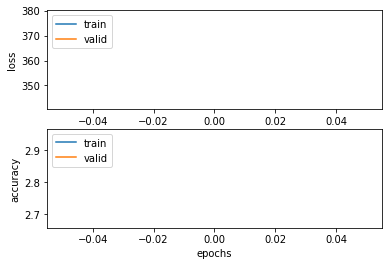

In [35]:
plot_2d(stats)

### Test

#### Classier's parameters

In [0]:
model_test(test_dataloader, net_pretrained_c)

#### Convolutional' parameters

In [0]:
model_test(test_dataloader, net_sgd_list[-1])

### Notes
- Batch_size increased to train convolutional layers, because training too slow with batch of 64, for the same reason increased learning rate (1e-3 --> 1e-2)
- batch 64, lr 1e-3 classifier --> 76.5% (3 epochs) validation
- batch 32, lr 1e-3/3 classifier --> 82.9% (7 epochs) test, 83.5% validation
- batch 256, cyclic lr 1e-2 -> 1e-3, convolutional --> 48.7% (40 epochs) validation

## Data augmentation
Training classier's parameters of pyTorch's implementation of AlexNet (freezing convolutional layers) with three different set of data transformation.

### Define Data Preprocessing 1
 Using mean and standard deviation of ImageNet

In [0]:
train_transform_1 = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.RandomRotation(degrees=20),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation                 
])

eval_transform_1 = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomRotation(degrees=20),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                                           
])

### Define Data Preprocessing 2
 Using mean and standard deviation of ImageNet

In [0]:
train_transform_2 = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomGrayscale(p=0.1),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])

eval_transform_2 = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomGrayscale(p=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                    
])

### Define Data Preprocessing 3
 Using mean and standard deviation of ImageNet

In [0]:
train_transform_3 = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.RandomRotation(degrees=5),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomGrayscale(p=0.1),
                                      transforms.RandomPerspective(),
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])

eval_transform_3 = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomRotation(degrees=5),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomGrayscale(p=0.1),
                                      transforms.RandomPerspective(),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                    
])

### Prepare Dataset

In [0]:
train_transform = train_transform_2
eval_transform = eval_transform_2

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, transform=train_transform, split='train')
test_dataset = Caltech(DATA_DIR, transform=eval_transform, split='test')
# Creating data indices for training and validation splits:
train_indices = []
val_indices = []

for image_class in train_dataset.classes:
  class_indices = train_dataset.get_index_by_class(image_class)
  np.random.shuffle(class_indices)
  split = int(np.floor(0.5 * len(class_indices)))
  train_indices = train_indices + class_indices[split:]
  val_indices = val_indices + class_indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_indices)))
print('Validation Dataset: {}'.format(len(val_indices)))
print('Test Dataset: {}'.format(len(test_dataset)))

### Prepare dataloaders

In [0]:
LR = 1e-3
BATCH_SIZE = 64
GAMMA = 0.11
STEP_SIZE = 5

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=train_sampler) #Shuffling in sampler
valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, drop_last=True, sampler=valid_sampler) #Shuffling in sampler
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

### Train

In [0]:
net_pretrained_da = alexnet(pretrained = True)
net_pretrained_da.classifier[6] = nn.Linear(4096, NUM_CLASSES)
parameters_to_optimize = net_pretrained_da.classifier.parameters()

#Using SGD + Nesterov momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) 
stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

In [0]:
stats = model_train(net_pretrained_da, optimizer, scheduler, stats)

In [0]:
plot_2d(stats)

### Comparing results
Transformation 1 leads to an accuracy of 76.8% on validation test.

Transformation 2 leads to an accuracy of 81.8% on validation test.

Transformation 3 leads to an accuracy of 79.2% on validation test.

Transformation 1+2 --> 83.8% on validation test

Transformation 1+3 --> 83.2% on validation test

Transformation 2+3 --> 83.5% on validation test

Transformation 1+2+3 --> 85.5% on validation test

In [0]:
model_test(valid_dataloader, net_pretrained_l[1], net2=[net_pretrained_l[0], net_pretrained_l[2]])

### Test
Testing using model train with transformation 1, 2 and 3, because this leads to better performances on validation set.

In [0]:
model_test(test_dataloader, net_pretrained_l[1], net2=[net_pretrained_l[2], net_pretrained_l[0]])

### Notes
1,2 and 3 --> 79.7% on test set

##VGG
Using hyper-parameters used in data augmentation, set 2 of tansformations and pretrained models.

Freezing only convolution's layers.

Step size = 5
batch size = 32

In [0]:
#Train
net_pretrained_vgg_19_bn = vgg19_bn(pretrained=True)
net_pretrained_vgg_19_bn.classifier[6] = nn.Linear(4096, NUM_CLASSES)
parameters_to_optimize = net_pretrained_vgg_19_bn.classifier.parameters()

#Using SGD + Nesterov momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA) 
stats = {'valid_losses': [], 'train_losses': [], 'valid_accuracies': [], 'train_accuracies': []}

In [0]:
stats = model_train(net_pretrained_vgg_19_bn, optimizer, scheduler, stats, epochs=20)

In [0]:
plot_2d(stats)

In [0]:
#Test
#model_test(valid_dataloader, net_pretrained_vgg_19, net2=[net_pretrained_vgg_11, net_pretrained_vgg_19_bn])
model_test(test_dataloader, net_pretrained_vgg_19, net2=[net_pretrained_vgg_11, net_pretrained_vgg_19_bn])

### Notes
Validation set

VGG A --> 87.2%

VGG E --> 88.6%

VGG E with batch normalization (lr = 1e-3, bs = 32) --> 89.7%

VGG E with batch normalization (lr = (1e-3)/2, bs = 32) --> 87.9%

A+E+Ebn --> 90.3%

Test set

A+E+Ebn --> 91.2%
